<h1> Logistic Regression using Spark ML </h1>

Set up bucket

In [16]:
BUCKET='qwiklabs-gcp-73e5e347eb5957c6'

os.environ['BUCKET'] = BUCKET

In a standalone script, we'd have to do:
<pre>
from pyspark.sql import SparkSession
from pyspark import SparkContext

sc = SparkContext('local', 'logistic')
spark = SparkSession \
    .builder \
    .appName("Logistic regression w/ Spark ML") \
    .getOrCreate()

</pre>
But in Datalab, spark and sc already exist

In [17]:
print spark
print sc

<SparkContext master=yarn appName=pyspark-shell>


In [18]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
print BUCKET

qwiklabs-gcp-73e5e347eb5957c6


<h2> Read dataset </h2>

In [19]:
traindays = spark.read \
    .option("header", "true") \
    .csv('gs://{}/flights/trainday.csv'.format(BUCKET))
traindays.createOrReplaceTempView('traindays')

In [20]:
spark.sql("SELECT * from traindays LIMIT 5").show()

+----------+------------+
|   FL_DATE|is_train_day|
+----------+------------+
|2015-01-01|        True|
|2015-01-04|        True|
|2015-01-05|        True|
|2015-01-07|        True|
|2015-01-08|        True|
+----------+------------+



In [21]:
from pyspark.sql.types import StringType, FloatType, StructType, StructField

header = 'FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME'

def get_structfield(colname):
   if colname in ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE', 'TAXI_OUT']:
      return StructField(colname, FloatType(), True)
   else:
      return StructField(colname, StringType(), True)

schema = StructType([get_structfield(colname) for colname in header.split(',')])

In [22]:
inputs = 'gs://{}/flights/tzcorr/all_flights-00004-*'.format(BUCKET) # 1/30th;  you may have to change this to find a shard that has training data
#inputs = 'gs://{}/flights/tzcorr/all_flights-*'.format(BUCKET)  # FULL
flights = spark.read\
            .schema(schema)\
            .csv(inputs)

# this view can now be queried ...
flights.createOrReplaceTempView('flights')

<h2> Clean up </h2>

In [23]:
trainquery = """
SELECT
  f.*
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True'
"""
traindata = spark.sql(trainquery)

In [24]:
print traindata.head(2)  # if this is empty, try changing the shard you are using.

[Row(FL_DATE=u'2015-07-16', UNIQUE_CARRIER=u'OO', AIRLINE_ID=u'20304', CARRIER=u'OO', FL_NUM=u'2880', ORIGIN_AIRPORT_ID=u'12892', ORIGIN_AIRPORT_SEQ_ID=u'1289203', ORIGIN_CITY_MARKET_ID=u'32575', ORIGIN=u'LAX', DEST_AIRPORT_ID=u'10140', DEST_AIRPORT_SEQ_ID=u'1014003', DEST_CITY_MARKET_ID=u'30140', DEST=u'ABQ', CRS_DEP_TIME=u'2015-07-16T20:45:00', DEP_TIME=u'2015-07-16T20:43:00', DEP_DELAY=-2.0, TAXI_OUT=26.0, WHEELS_OFF=u'2015-07-16T21:09:00', WHEELS_ON=u'2015-07-16T22:44:00', TAXI_IN=u'5.00', CRS_ARR_TIME=u'2015-07-16T22:49:00', ARR_TIME=u'2015-07-16T22:49:00', ARR_DELAY=0.0, CANCELLED=u'0.00', CANCELLATION_CODE=None, DIVERTED=u'0.00', DISTANCE=677.0, DEP_AIRPORT_LAT=u'33.94250000', DEP_AIRPORT_LON=u'-118.40805556', DEP_AIRPORT_TZOFFSET=u'-25200.0', ARR_AIRPORT_LAT=u'35.03888889', ARR_AIRPORT_LON=u'-106.60833333', ARR_AIRPORT_TZOFFSET=u'-21600.0', EVENT=None, NOTIFY_TIME=None), Row(FL_DATE=u'2015-07-16', UNIQUE_CARRIER=u'OO', AIRLINE_ID=u'20304', CARRIER=u'OO', FL_NUM=u'2881', ORIGIN_

In [25]:
traindata.describe().show()

+-------+----------+--------------+------------------+-------+-----------------+------------------+---------------------+---------------------+------+------------------+-------------------+-------------------+------+-------------------+-------------------+------------------+-----------------+-------------------+-------------------+-----------------+-------------------+-------------------+-----------------+--------------------+-----------------+--------------------+-----------------+-----------------+------------------+--------------------+-----------------+------------------+--------------------+-----+-----------+
|summary|   FL_DATE|UNIQUE_CARRIER|        AIRLINE_ID|CARRIER|           FL_NUM| ORIGIN_AIRPORT_ID|ORIGIN_AIRPORT_SEQ_ID|ORIGIN_CITY_MARKET_ID|ORIGIN|   DEST_AIRPORT_ID|DEST_AIRPORT_SEQ_ID|DEST_CITY_MARKET_ID|  DEST|       CRS_DEP_TIME|           DEP_TIME|         DEP_DELAY|         TAXI_OUT|         WHEELS_OFF|          WHEELS_ON|          TAXI_IN|       CRS_ARR_TIME|       

Note that the counts for the various columns are all different; We have to remove NULLs in the delay variables (these correspond to canceled or diverted flights).

<h2> Logistic regression </h2>

In [26]:
trainquery = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' AND
  f.dep_delay IS NOT NULL AND 
  f.arr_delay IS NOT NULL
"""
traindata = spark.sql(trainquery)
traindata.describe().show()

+-------+------------------+------------------+-----------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|        ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+-----------------+-----------------+
|  count|            150945|            150945|           150945|           150945|
|   mean|10.672973599655503|16.110821822518137|5.310126204909073|838.4892046772003|
| stddev| 36.29471283461898| 8.879085146598761|38.04559816976176|623.1392192724009|
|    min|             -39.0|               1.0|            -68.0|             31.0|
|    max|            1393.0|             168.0|           1364.0|           4983.0|
+-------+------------------+------------------+-----------------+-----------------+



In [27]:
trainquery = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' AND
  f.CANCELLED == '0.00' AND 
  f.DIVERTED == '0.00'
"""
traindata = spark.sql(trainquery)
traindata.describe().show()

+-------+------------------+------------------+-----------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|        ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+-----------------+-----------------+
|  count|            150945|            150945|           150945|           150945|
|   mean|10.672973599655503|16.110821822518137|5.310126204909073|838.4892046772003|
| stddev| 36.29471283461898| 8.879085146598761|38.04559816976176|623.1392192724009|
|    min|             -39.0|               1.0|            -68.0|             31.0|
|    max|            1393.0|             168.0|           1364.0|           4983.0|
+-------+------------------+------------------+-----------------+-----------------+



In [28]:
def to_example(fields):
  return LabeledPoint(\
              float(fields['ARR_DELAY'] < 15), #ontime? \
              [ \
                  fields['DEP_DELAY'], \
                  fields['TAXI_OUT'],  \
                  fields['DISTANCE'],  \
              ])

In [29]:
examples = traindata.rdd.map(to_example)

In [30]:
lrmodel = LogisticRegressionWithLBFGS.train(examples, intercept=True)
print lrmodel.weights,lrmodel.intercept

[-0.17315525007026508,-0.1237035778118081,0.00047521823417019643] 5.26368986835


In [31]:
print lrmodel.predict([6.0,12.0,594.0])
print lrmodel.predict([36.0,12.0,594.0])

1
0


In [32]:
lrmodel.clearThreshold()
print lrmodel.predict([6.0,12.0,594.0])
print lrmodel.predict([36.0,12.0,594.0])

0.953584521178
0.102287495268


In [33]:
lrmodel.setThreshold(0.7) # cancel if prob-of-ontime < 0.7
print lrmodel.predict([6.0,12.0,594.0])
print lrmodel.predict([36.0,12.0,594.0])

1
0


<h2> Predict with the model </h2>

First save the model

In [34]:
!gsutil -m rm -r gs://$BUCKET/flights/sparkmloutput/model



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Removing gs://qwiklabs-gcp-73e5e347eb5957c6/flights/sparkmloutput/model/#1558106468991824...
Removing gs://qwiklabs-gcp-73e5e347eb5957c6/flights/sparkmloutput/model/data/part-00000-3c7272fe-eee1-403d-82fe-1ab6fb9ce1d8-c000.snappy.parquet#1558106478668539...
Removing gs://qwiklabs-gcp-73e5e347eb5957c6/flights/sparkmloutput/model/data/#1558106475046827...
Removing gs://qwiklabs-gcp-73e5e347eb5957c6/flights/sparkmloutput/model/data/_SUCCESS#1558106480577966...
Removing gs://qwiklabs-gcp-73e5e347eb5957c6/flights/sparkmloutput/model/metadata/#1558106469019245...
Removing gs://qwiklabs-gcp-73e5e347eb5957c6/flights/sparkmloutput/model/metadata/_SUCCESS#1558106474150584...
Removing gs://qwiklabs-gcp-73e5e347eb5957c6/flights/sparkmloutput/model/metadata/part-00000#1558106472146678...
/ [7/7 objects] 100% Done                                                       
Operation complete

In [35]:
MODEL_FILE='gs://' + BUCKET + '/flights/sparkmloutput/model'

In [36]:
lrmodel.save(sc, MODEL_FILE)
print '{} saved'.format(MODEL_FILE)

gs://qwiklabs-gcp-73e5e347eb5957c6/flights/sparkmloutput/model saved


In [37]:
lrmodel = 0
print lrmodel

0


Now retrieve the model

In [38]:
from pyspark.mllib.classification import LogisticRegressionModel
lrmodel = LogisticRegressionModel.load(sc, MODEL_FILE)
lrmodel.setThreshold(0.7)

In [39]:
print lrmodel.predict([36.0,12.0,594.0])

0


In [40]:
print lrmodel.predict([8.0,4.0,594.0])

1


<h2> Examine the model behavior </h2>

For dep_delay=20 and taxiout=10, how does the distance affect prediction?

In [41]:
lrmodel.clearThreshold() # to make the model produce probabilities
print lrmodel.predict([20, 10, 500])

0.690222178075


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
dist = np.arange(10, 2000, 10)
prob = [lrmodel.predict([20, 10, d]) for d in dist]

Text(0,0.5,u'probability of ontime arrival')

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


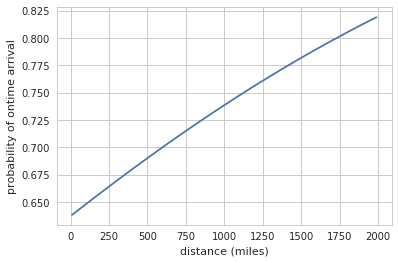

In [43]:
sns.set_style("whitegrid")
ax = plt.plot(dist, prob)
plt.xlabel('distance (miles)')
plt.ylabel('probability of ontime arrival')

Text(0,0.5,u'probability of ontime arrival')

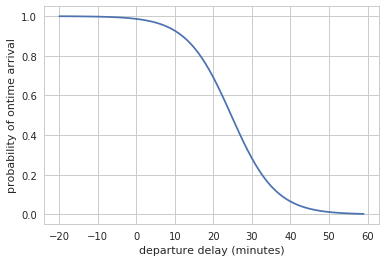

In [44]:
delay = np.arange(-20, 60, 1)
prob = [lrmodel.predict([d, 10, 500]) for d in delay]
ax = plt.plot(delay, prob)
plt.xlabel('departure delay (minutes)')
plt.ylabel('probability of ontime arrival')

<h2> Evaluate model </h2>

Evaluate on the test data

In [45]:
inputs = 'gs://{}/flights/tzcorr/all_flights-00001-*'.format(BUCKET) # you may have to change this to find a shard that has test data
flights = spark.read\
            .schema(schema)\
            .csv(inputs)
flights.createOrReplaceTempView('flights')
testquery = trainquery.replace("t.is_train_day == 'True'","t.is_train_day == 'False'")
print testquery


SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'False' AND
  f.CANCELLED == '0.00' AND 
  f.DIVERTED == '0.00'



In [46]:
testdata = spark.sql(testquery)
examples = testdata.rdd.map(to_example)

In [47]:
testdata.describe().show()  # if this is empty, change the shard you are using

+-------+------------------+------------------+------------------+------------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|          DISTANCE|
+-------+------------------+------------------+------------------+------------------+
|  count|              4446|              4446|              4446|              4446|
|   mean| 4.430274403958615|16.800944669365723|-2.338056680161943|1071.2802519118309|
| stddev|30.778923898832627| 7.025949587873235|32.316686968965506|  686.857994962002|
|    min|             -26.0|               2.0|             -53.0|              31.0|
|    max|            1284.0|              86.0|            1289.0|            3784.0|
+-------+------------------+------------------+------------------+------------------+



In [48]:
def eval(labelpred):
    cancel = labelpred.filter(lambda (label, pred): pred < 0.7)
    nocancel = labelpred.filter(lambda (label, pred): pred >= 0.7)
    corr_cancel = cancel.filter(lambda (label, pred): label == int(pred >= 0.7)).count()
    corr_nocancel = nocancel.filter(lambda (label, pred): label == int(pred >= 0.7)).count()
    
    cancel_denom = cancel.count()
    nocancel_denom = nocancel.count()
    if cancel_denom == 0:
        cancel_denom = 1
    if nocancel_denom == 0:
        nocancel_denom = 1
    return {'total_cancel': cancel.count(), \
            'correct_cancel': float(corr_cancel)/cancel_denom, \
            'total_noncancel': nocancel.count(), \
            'correct_noncancel': float(corr_nocancel)/nocancel_denom \
           }

# Evaluate model
lrmodel.clearThreshold() # so it returns probabilities
labelpred = examples.map(lambda p: (p.label, lrmodel.predict(p.features)))
print 'All flights:'
print eval(labelpred)

# keep only those examples near the decision threshold
print 'Flights near decision threshold:'
labelpred = labelpred.filter(lambda (label, pred): pred > 0.65 and pred < 0.75)
print eval(labelpred)

All flights:
{'correct_cancel': 0.7571942446043165, 'total_noncancel': 3890, 'correct_noncancel': 0.9763496143958869, 'total_cancel': 556}
Flights near decision threshold:
{'correct_cancel': 0.28125, 'total_noncancel': 47, 'correct_noncancel': 0.851063829787234, 'total_cancel': 32}
